## Predicting clusters using financial indicators and institutional characteristics (2012-2023)

### Created in Dec 1, 2025


In [660]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor  # or other ML model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
# (optional) For panel-data / fixed-effect modeling
from fixedeffect.fe import fixedeffect  # from package FixedEffectModel  OR
# or: import linearmodels (or pydynpd) for dynamic panel data modeling if desired

from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans


In [661]:
data = pd.read_csv('financial_analyze1201.csv')
data.head()

# Financial data only have 1404 institutions, all variables are same with initial_analyze1027.csv


,unitid,instnm,addr,city,stabbr,zip,fips,obereg,chfnm,chftitle,...,erll_dist_perc,missing,close,pcert,pcertde,hdegofr1_cat,idx_parent,parent_flag,n,N
0,100654,Alabama A & M University,4900 Meridian Street,Normal,AL,35762,1,5,Dr. Daniel K. Wims,President,...,4.593084,NaN,NaN,0,0,Doctor's degree,-2,NaN,1,12
1,100654,Alabama A & M University,4900 Meridian Street,Normal,AL,35762,1,5,Dr. Daniel K. Wims,President,...,4.734411,NaN,NaN,0,0,Doctor's degree,-2,NaN,2,12
2,100654,Alabama A & M University,4900 Meridian Street,Normal,AL,35762,1,5,"Dr. Andrew Hugine, Jr.",President,...,4.393880,NaN,NaN,0,0,Doctor's degree,-2,NaN,3,12
3,100654,Alabama A & M University,4900 Meridian Street,Normal,AL,35762,1,5,"Dr. Andrew Hugine, Jr.",President,...,1.503006,NaN,NaN,0,0,Doctor's degree,-2,NaN,4,12
4,100654,Alabama A & M University,4900 Meridian Street,Normal,AL,35762,1,5,"Dr. Andrew Hugine, Jr.",President,...,1.409619,NaN,NaN,0,0,Doctor's degree,-2,NaN,5,12


In [662]:
data['unitid'].nunique()  # number of unique entities

1404

In [663]:
cluster = pd.read_csv('data_with_inst_clusters1027.csv')
# make cluster with unique unitids
cluster = cluster[['unitid', 'inst_cluster']].drop_duplicates()

In [664]:
cluster.shape

(1584, 2)

In [665]:
# merge cluster info
data = data.merge(cluster[['unitid', 'inst_cluster']], on='unitid', how='left')

In [666]:
data.shape #(16628, 704)

(16628, 704)

In [667]:

data['unitid'].value_counts()

unitid
100654    12
205443    12
206914    12
206695    12
206446    12
          ..
102711     2
262086     2
223214     2
165884     2
498571     2
Name: count, Length: 1404, dtype: int64

In [668]:
data['inst_cluster'].value_counts()

inst_cluster
0    7244
1    5815
2    3569
Name: count, dtype: int64

In [669]:
# make a new column urbanicity based on locale
# locale: 11,12,13 = City; 21,22,23 = Suburb; 31,32,33 = Town; 41,42,43 = Rural
# label define label_locale 11 "City: Large"
# label define label_locale 12 "City: Midsize",add
# label define label_locale 13 "City: Small",add
# label define label_locale 21 "Suburb: Large",add
# label define label_locale 22 "Suburb: Midsize",add
# label define label_locale 23 "Suburb: Small",add
# label define label_locale 31 "Town: Fringe",add
# label define label_locale 32 "Town: Distant",add
# label define label_locale 33 "Town: Remote",add
# label define label_locale 41 "Rural: Fringe",add
# label define label_locale 42 "Rural: Distant",add
# label define label_locale 43 "Rural: Remote",add
# label define label_locale -3 "{Not available}",add

# make locale below 0 is missing
data['locale'] = data['locale'].apply(lambda x: x if x > 0 else np.nan)
data['instsize'] = data['instsize'].apply(lambda x: np.nan if x < 0 else x)

data['urbanicity'] = data['locale'].apply(lambda x: 'City' if x in [11,12,13] else ('Suburb' if x in [21,22,23] else ('Town' if x in [31,32,33] else ('Rural' if x in [41,42,43] else np.nan))))

In [670]:
def map_carnegie(c21basic):
    if c21basic in range(1, 10):
        return 5
    elif c21basic in range(10, 14):
        return 6
    elif c21basic in [21, 22]:
        return 3
    elif c21basic == 14 or c21basic == 23:
        return 4
    elif c21basic in range(15, 18):
        return 1
    elif c21basic in range(18, 21):
        return 2
    elif c21basic in range(24, 33):
        return 6
    elif c21basic == 33:
        return 7
    else:
        return np.nan  
    
data['carnegie21'] = data['c21basic'].apply(map_carnegie)

data['carnegie21'].value_counts()



carnegie21
5.0    8616
2.0    2751
1.0    2320
4.0    1341
3.0     888
6.0     364
7.0     322
Name: count, dtype: int64

In [671]:
def map_carnegie10(ccbasic):
    if ccbasic in range(1, 15):
        return 5
    elif ccbasic in range(15, 18):
        return 1
    elif ccbasic in range(18, 21):
        return 2
    elif ccbasic in range(21, 23):
        return 3
    elif ccbasic == 23:
        return 4
    elif ccbasic in range(24, 33):
        return 6
    elif ccbasic == 33:
        return 7
    else:
        return np.nan  
    
data['carnegie10'] = data['ccbasic'].apply(map_carnegie10)

data['carnegie10'].value_counts()

carnegie10
5.0    9797
2.0    2996
1.0    1740
3.0     998
7.0     305
4.0     264
6.0     256
Name: count, dtype: int64

### Financial variables
- f1b01: tuition and fees revenues
- f1b10: federal appropriations
- f1b11: state appropriations
- f1b12: local appropriations
- f1n01: operating income + net nonoperating revenues
- f1n03: change in net position
- f1n05: expendable net assets
- f1n06: plant-related debt
- f1n07: total expenses

In [672]:
finance = ['f1b01', 'f1b10', 'f1b11', 'f1b12', 'f1n01', 'f1n03', 'f1n05', 'f1n06']

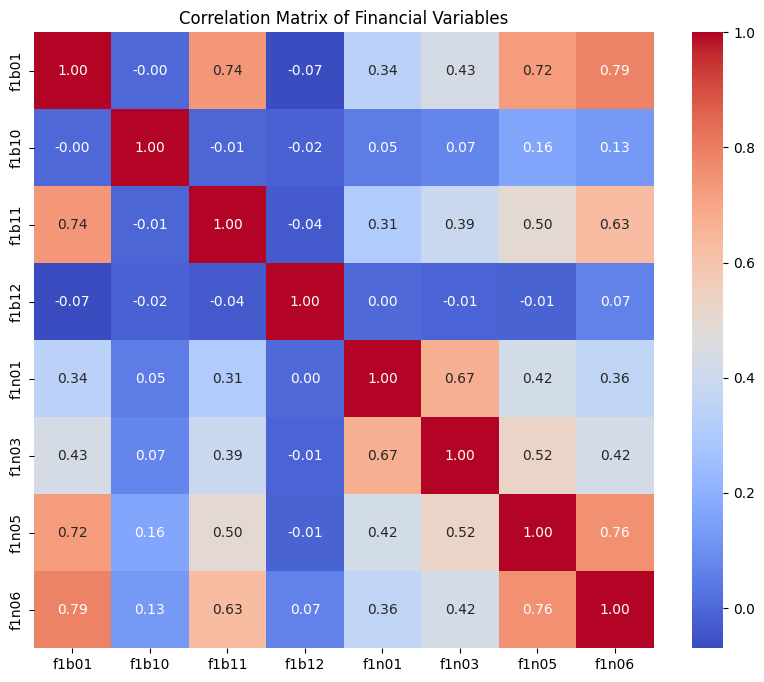

In [673]:
# check multicollinearity
corr_matrix = data[finance].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Financial Variables')
plt.show()

### There exists multicollinearity in selected features
- In the models, we only use f1b01, f1b10, and f1b12

In [674]:
# sort data
data = data.sort_values(by=['unitid', 'year'])
# create lagged features for f1b01 ,f1b10, f1b12
for var in ['f1b01', 'f1b10', 'f1b12', 'eftotlt3']:
    data[f'{var}_lag1'] = data.groupby('unitid')[var].shift(1)
    data[f'{var}_lag2'] = data.groupby('unitid')[var].shift(2)
    data[f'{var}_lag3'] = data.groupby('unitid')[var].shift(3)
    data[f'{var}_lag4'] = data.groupby('unitid')[var].shift(4)
    data[f'{var}_lag5'] = data.groupby('unitid')[var].shift(5)

In [675]:
# only keep categorical variables and financial variables
data = data[['year', 'fips', 'hbcu','tribal', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10', 'inst_cluster', 'eftotlt3','eftotlt3_lag1', 'eftotlt3_lag2', 'eftotlt3_lag3', 'eftotlt3_lag4', 'eftotlt3_lag5', 'f1b01','f1b10', 'f1b12', 'f1b01_lag1', 'f1b01_lag2', 'f1b01_lag3', 'f1b01_lag4', 'f1b01_lag5', 'f1b10_lag1', 'f1b10_lag2', 'f1b10_lag3', 'f1b10_lag4', 'f1b10_lag5', 'f1b12_lag1', 'f1b12_lag2', 'f1b12_lag3', 'f1b12_lag4', 'f1b12_lag5']]

In [676]:
# make 'fips', 'hbcu', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10' categorical variables
data['fips'] = data['fips'].astype('category')
data['hbcu'] = data['hbcu'].astype('category')
data['tribal'] = data['tribal'].astype('category')
data['urbanicity'] = data['urbanicity'].astype('category')
data['instsize'] = data['instsize'].astype('category')
data['carnegie21'] = data['carnegie21'].astype('category')
data['carnegie10'] = data['carnegie10'].astype('category')
data['inst_cluster'] = data['inst_cluster'].astype('category')

# make categorical features same for institutions in different years
data = data[data['year'] == 2023]

In [677]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1396 entries, 0 to 16626
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   year           1396 non-null   int64   
 1   fips           1396 non-null   category
 2   hbcu           1396 non-null   category
 3   tribal         1396 non-null   category
 4   urbanicity     1393 non-null   category
 5   instsize       1396 non-null   category
 6   carnegie21     1395 non-null   category
 7   carnegie10     1368 non-null   category
 8   inst_cluster   1396 non-null   category
 9   eftotlt3       1396 non-null   int64   
 10  eftotlt3_lag1  1396 non-null   float64 
 11  eftotlt3_lag2  1389 non-null   float64 
 12  eftotlt3_lag3  1389 non-null   float64 
 13  eftotlt3_lag4  1389 non-null   float64 
 14  eftotlt3_lag5  1387 non-null   float64 
 15  f1b01          1387 non-null   float64 
 16  f1b10          1387 non-null   float64 
 17  f1b12          1387 non-null   float6

### Predict inst_cluster

In [678]:
# train test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
X_train = train_data.drop(columns=['inst_cluster', 'year'])
y_train = train_data['inst_cluster']
X_test = test_data.drop(columns=['inst_cluster', 'year'])
y_test = test_data['inst_cluster']

In [679]:
# imputation for missing values and normalization
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


# one-hot encoding for categorical variables will be done in modeling step
cat = ['fips', 'hbcu', 'tribal', 'urbanicity', 'instsize', 'carnegie21', 'carnegie10']
num = ['eftotlt3', 'f1b01','f1b10', 'f1b12', 'f1b01_lag1', 'f1b01_lag2', 'f1b10_lag1', 'f1b10_lag2', 'f1b12_lag1', 'f1b12_lag2']
# Ensure categorical columns are cast to string type before pipeline
X_train[cat] = X_train[cat].astype(str)
X_test[cat]  = X_test[cat].astype(str)

# Create column transformer for different preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat)   
])

# Create pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

pipline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])



In [680]:
# fit and evaluate
# Random Forest
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf)) 
# XGBoost
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
# KNN
pipline_knn.fit(X_train, y_train)
y_pred_knn = pipline_knn.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       120
           1       0.55      0.49      0.52        93
           2       0.62      0.37      0.47        67

    accuracy                           0.57       280
   macro avg       0.58      0.53      0.54       280
weighted avg       0.57      0.57      0.56       280



/Users/melodywang/University of Michigan Dropbox/Meng Wang/SI618/SI_618_FA_24_Files/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:01:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.73      0.63       120
           1       0.53      0.45      0.49        93
           2       0.59      0.36      0.44        67

    accuracy                           0.55       280
   macro avg       0.55      0.51      0.52       280
weighted avg       0.55      0.55      0.54       280

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       120
           1       0.51      0.44      0.47        93
           2       0.48      0.21      0.29        67

    accuracy                           0.52       280
   macro avg       0.51      0.47      0.46       280
weighted avg       0.51      0.52      0.49       280



In [681]:
# # TO_DO: SHAP for model interpretation

# import shap

# # After you train your Random Forest or XGBoost model
# # For example, using your RandomForestClassifier
# model = model_rf  # or model_xgb depending which you want to explain

# # 1. Initialize JS visualization (if in notebook)
# shap.initjs()

# # 2. Create SHAP explainer for a tree-based model
# explainer = shap.TreeExplainer(model)

# # 3. Compute SHAP values for your test set (or any dataset X)
# shap_values = explainer(X_test)

# # 4. Global summary — feature importance across test set

# # 5. More detailed global view — all points (shows distribution of impacts)
# shap.summary_plot(shap_values, X_test)

# # 6. For local interpretation (one institution / observation)
# i = 0  # index of the instance you want to inspect
# shap.force_plot(explainer.expected_value, shap_values.values[i,:], X_test.iloc[i,:], matplotlib=True)

# # 7. (Optional) dependence plot — how one feature’s value relates to its impact
# shap.dependence_plot("some_feature_name", shap_values, X_test)
